In [1]:
'''
reference from http://napitupulu-jon.appspot.com/posts/titanic.html

survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)
'''


import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('darkgrid')
import numpy as np
import scipy.stats as sp
import sklearn
from sklearn.cross_validation import cross_val_score, train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.svm import SVC
from sklearn import tree
import sklearn.ensemble as ske

/home/rong/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('titanic_data.csv')

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.shape

(891, 12)

In [5]:
df.Name.nunique()

891

In [6]:
df.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

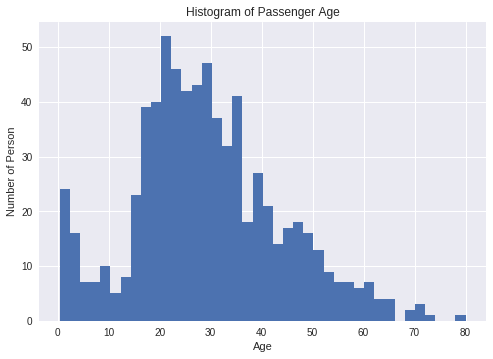

In [7]:
df.Age.hist(bins=40)
plt.xlabel("Age")
plt.ylabel("Number of Person")
plt.title("Histogram of Passenger Age");

In [8]:
def compute_freq_chi2(x,y):
    """This function will compute frequency table of x an y
    Pandas Series, and use the table to feed for the contigency table
    
    Parameters:
    -------
    x,y : Pandas Series, must be same shape for frequency table
    
    Return:
    -------
    None. But prints out frequency table, chi2 test statistic, and 
    p-value
    """
    freqtab = pd.crosstab(x,y)
    print("Frequency table")
    print("============================")
    print(freqtab)
    print("============================")
    chi2,pval,dof,expected = sp.chi2_contingency(freqtab)
    print("ChiSquare test statistic: ",chi2)
    print("p-value: ",pval)
    return

In [9]:
df['WomenChildren'] = np.where((df.Age <= 12) | (df.Sex == 'female'),1,0)
compute_freq_chi2(df.Survived,df.WomenChildren)

Frequency table
WomenChildren    0    1
Survived               
0              452   97
1               88  254
ChiSquare test statistic:  280.393048965
p-value:  6.16515742548e-63


In [10]:
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
df['age_group'] = pd.cut(df.Age, range(0, 81, 10), right=False, labels=age_labels)
compute_freq_chi2(df.Survived,df.age_group)

Frequency table
age_group  0-9  10-19  20-29  30-39  40-49  50-59  60-69  70-79
Survived                                                       
0           24     61    143     94     55     28     13      6
1           38     41     77     73     34     20      6      0
ChiSquare test statistic:  19.5300559831
p-value:  0.006679417371


In [11]:
compute_freq_chi2(df.Survived,df.Sex)

Frequency table
Sex       female  male
Survived              
0             81   468
1            233   109
ChiSquare test statistic:  260.717020167
p-value:  1.19735706278e-58


In [12]:
compute_freq_chi2(df.Survived,df.Pclass)

Frequency table
Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119
ChiSquare test statistic:  102.888988757
p-value:  4.5492517113e-23


In [13]:
compute_freq_chi2(df.Survived,df.SibSp)

Frequency table
SibSp       0    1   2   3   4  5  8
Survived                            
0         398   97  15  12  15  5  7
1         210  112  13   4   3  0  0
ChiSquare test statistic:  37.2717929152
p-value:  1.55858104659e-06


In [14]:
compute_freq_chi2(df.Survived,df.Parch)
print(pd.crosstab(df.Survived,df.Parch))

Frequency table
Parch       0   1   2  3  4  5  6
Survived                         
0         445  53  40  2  4  4  1
1         233  65  40  3  0  1  0
ChiSquare test statistic:  27.9257840602
p-value:  9.70352642104e-05
Parch       0   1   2  3  4  5  6
Survived                         
0         445  53  40  2  4  4  1
1         233  65  40  3  0  1  0


In [15]:
compute_freq_chi2(df.Survived,df.Embarked)

Frequency table
Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217
ChiSquare test statistic:  26.4891498392
p-value:  1.76992228412e-06


In [16]:
cabinTable=(df[(df.Pclass == 1)]
 .groupby([df.Cabin.str[:1],'Survived'])
 .PassengerId
 .count()
 .unstack())

In [17]:
df['CabinClass'] = df.Cabin.str[:1]

In [18]:
compute_freq_chi2(df.Survived,df.CabinClass)

Frequency table
CabinClass  A   B   C   D   E  F  G  T
Survived                              
0           8  12  24   8   8  5  2  1
1           7  35  35  25  24  8  2  0
ChiSquare test statistic:  10.3005563135
p-value:  0.172171341282


In [19]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,WomenChildren,age_group,CabinClass
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,20-29,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,30-39,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,20-29,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,30-39,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,30-39,NaN


In [20]:
df.drop(df.columns[[ 3, 8, 10,12,13, 14]], axis=1, inplace=True) 

In [21]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

In [22]:
def process_ports(df):
    if len(df.Age[df.Embarked.isnull()]) > 0:
        df.loc[(df.Embarked.isnull()), 'Embarked'] = '$'
    le = preprocessing.LabelEncoder()
    df['Embarked'] = le.fit_transform(df['Embarked'])
    return df

In [23]:
process_ports(df)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,3
1,2,1,1,female,38.0,1,0,71.2833,1
2,3,1,3,female,26.0,0,0,7.9250,3
3,4,1,1,female,35.0,1,0,53.1000,3
4,5,0,3,male,35.0,0,0,8.0500,3
5,6,0,3,male,NaN,0,0,8.4583,2
6,7,0,1,male,54.0,0,0,51.8625,3
7,8,0,3,male,2.0,3,1,21.0750,3
8,9,1,3,female,27.0,0,2,11.1333,3
9,10,1,2,female,14.0,1,0,30.0708,1


In [24]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

In [25]:
df["Sex"] = df["Sex"].apply(lambda sex:1 if sex=="male" else 0)
df["Age"] = df["Age"].fillna(df["Age"].mean())
#df["Fare"] = df["Fare"].fillna(df["Fare"].mean())

In [26]:
#df.isnull().sum()

In [27]:
survived = df["Survived"].values
#data = df[cols].values

In [28]:
data = df.loc[:, df.columns != 'Survived'].values

In [29]:
data_train, data_test, target_train, target_test = sklearn.cross_validation.train_test_split(data, survived,test_size=0.2, random_state=43)

In [30]:
model=LogisticRegression()
model.fit(data_train,target_train)
predictedProbLR = model.predict_proba(data_test)
predictedLR = model.predict(data_test).astype(int)

In [31]:
accuracyLR = accuracy_score(target_test, predictedLR)

In [32]:
print(accuracyLR)

0.743016759777


In [33]:
predictedProbLR.shape

(179, 2)

In [34]:
print(predictedProbLR)

[[ 0.88135082  0.11864918]
 [ 0.06359872  0.93640128]
 [ 0.74377389  0.25622611]
 [ 0.34266242  0.65733758]
 [ 0.94117441  0.05882559]
 [ 0.18197036  0.81802964]
 [ 0.88461656  0.11538344]
 [ 0.63876876  0.36123124]
 [ 0.33925444  0.66074556]
 [ 0.86642779  0.13357221]
 [ 0.25781745  0.74218255]
 [ 0.88510071  0.11489929]
 [ 0.81819398  0.18180602]
 [ 0.87834253  0.12165747]
 [ 0.79592079  0.20407921]
 [ 0.90106646  0.09893354]
 [ 0.30062077  0.69937923]
 [ 0.9480958   0.0519042 ]
 [ 0.51605763  0.48394237]
 [ 0.90392256  0.09607744]
 [ 0.93906245  0.06093755]
 [ 0.21717614  0.78282386]
 [ 0.77621226  0.22378774]
 [ 0.87505892  0.12494108]
 [ 0.90763199  0.09236801]
 [ 0.957008    0.042992  ]
 [ 0.55919136  0.44080864]
 [ 0.38770201  0.61229799]
 [ 0.88911248  0.11088752]
 [ 0.82016166  0.17983834]
 [ 0.69468928  0.30531072]
 [ 0.86620108  0.13379892]
 [ 0.38216224  0.61783776]
 [ 0.72825861  0.27174139]
 [ 0.90112059  0.09887941]
 [ 0.62156627  0.37843373]
 [ 0.87223506  0.12776494]
 

In [35]:
modelSVC=sklearn.svm.SVC(probability=True)
modelSVC.fit(data_train,target_train)
predictedProbSVC = modelSVC.predict_proba(data_test)
predictedSVC = modelSVC.predict(data_test).astype(int)

In [36]:
accuracySVC = accuracy_score(target_test, predictedSVC)

In [37]:
print(accuracySVC)

0.614525139665


In [38]:
print(predictedProbSVC)
predictedProbSVC.shape

[[ 0.61564707  0.38435293]
 [ 0.61565372  0.38434628]
 [ 0.61564782  0.38435218]
 [ 0.61565473  0.38434527]
 [ 0.61565372  0.38434628]
 [ 0.61565372  0.38434628]
 [ 0.61564648  0.38435352]
 [ 0.61565372  0.38434628]
 [ 0.61565372  0.38434628]
 [ 0.61565131  0.38434869]
 [ 0.61565239  0.38434761]
 [ 0.61350298  0.38649702]
 [ 0.61593104  0.38406896]
 [ 0.61565372  0.38434628]
 [ 0.61565371  0.38434629]
 [ 0.61565352  0.38434648]
 [ 0.61560073  0.38439927]
 [ 0.61565372  0.38434628]
 [ 0.61565372  0.38434628]
 [ 0.61525493  0.38474507]
 [ 0.61575438  0.38424562]
 [ 0.61564449  0.38435551]
 [ 0.61518262  0.38481738]
 [ 0.6155956   0.3844044 ]
 [ 0.61526331  0.38473669]
 [ 0.61565372  0.38434628]
 [ 0.61652593  0.38347407]
 [ 0.61612446  0.38387554]
 [ 0.61594475  0.38405525]
 [ 0.61565367  0.38434633]
 [ 0.61565372  0.38434628]
 [ 0.61473158  0.38526842]
 [ 0.61719977  0.38280023]
 [ 0.61565372  0.38434628]
 [ 0.61565141  0.38434859]
 [ 0.61565381  0.38434619]
 [ 0.61565372  0.38434628]
 

(179, 2)

In [39]:
sklearn.metrics.pairwise.cosine_similarity(predictedProbSVC, predictedProbLR,dense_output=True)

array([[ 0.9113339 ,  0.58583914,  0.97449446, ...,  0.95814643,
         0.90526343,  0.86695943],
       [ 0.9113391 ,  0.58582891,  0.97449729, ...,  0.95815004,
         0.90526879,  0.86695314],
       [ 0.91133448,  0.58583799,  0.97449478, ...,  0.95814683,
         0.90526403,  0.86695872],
       ..., 
       [ 0.9106188 ,  0.58724335,  0.97410392, ...,  0.95764865,
         0.90452548,  0.8678222 ],
       [ 0.91135008,  0.58580728,  0.97450328, ...,  0.95815768,
         0.90528013,  0.86693984],
       [ 0.91029473,  0.58787735,  0.97392647, ...,  0.95742275,
         0.9041911 ,  0.86821124]])

In [40]:
# http://www.discoveringdata.co.uk/code-tutorial-blog/getting-started-in-machine-learning-the-titanic-dataset
clf_dt = sklearn.tree.DecisionTreeClassifier(max_depth=10)
clf_dt = clf_dt.fit(data_train,target_train)

print(clf_dt.score(data_test,target_test))

0.748603351955


In [41]:
predictedProbDT = clf_dt.predict_proba(data_test)

In [42]:
print(predictedProbDT)

[[ 1.          0.        ]
 [ 1.          0.        ]
 [ 0.86792453  0.13207547]
 [ 0.125       0.875     ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 0.          1.        ]
 [ 1.          0.        ]
 [ 0.86792453  0.13207547]
 [ 0.86792453  0.13207547]
 [ 1.          0.        ]
 [ 0.86792453  0.13207547]
 [ 0.53846154  0.46153846]
 [ 1.          0.        ]
 [ 0.          1.        ]
 [ 1.          0.        ]
 [ 0.86792453  0.13207547]
 [ 0.          1.        ]
 [ 0.86792453  0.13207547]
 [ 0.86792453  0.13207547]
 [ 0.          1.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 0.          1.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 0.          1.        ]
 [ 1.          0.        ]
 [ 0.          1.        ]
 [ 0.125       0.875     ]
 [ 1.          0.        ]
 [ 0.          1.        ]
 [ 0.          1.        ]
 

In [43]:
predictedProbDT.shape

(179, 2)

In [44]:
clf_rf = ske.RandomForestClassifier(n_estimators=50)
clf_rf = clf_rf.fit(data_train,target_train)

print(clf_rf.score(data_test,target_test))

0.787709497207


In [50]:
predictedProbRF = clf_rf.predict_proba(data_test)

In [51]:
print(predictedProbRF)

[[ 0.98  0.02]
 [ 0.08  0.92]
 [ 0.76  0.24]
 [ 0.32  0.68]
 [ 0.68  0.32]
 [ 0.32  0.68]
 [ 0.96  0.04]
 [ 0.52  0.48]
 [ 0.4   0.6 ]
 [ 0.98  0.02]
 [ 0.22  0.78]
 [ 0.86  0.14]
 [ 0.66  0.34]
 [ 0.76  0.24]
 [ 0.92  0.08]
 [ 0.98  0.02]
 [ 0.66  0.34]
 [ 0.66  0.34]
 [ 0.48  0.52]
 [ 0.92  0.08]
 [ 0.82  0.18]
 [ 0.24  0.76]
 [ 0.92  0.08]
 [ 0.78  0.22]
 [ 0.72  0.28]
 [ 0.9   0.1 ]
 [ 0.62  0.38]
 [ 0.5   0.5 ]
 [ 0.9   0.1 ]
 [ 0.98  0.02]
 [ 0.52  0.48]
 [ 0.94  0.06]
 [ 0.06  0.94]
 [ 0.6   0.4 ]
 [ 0.98  0.02]
 [ 0.28  0.72]
 [ 0.42  0.58]
 [ 0.7   0.3 ]
 [ 0.8   0.2 ]
 [ 0.    1.  ]
 [ 0.88  0.12]
 [ 0.94  0.06]
 [ 0.82  0.18]
 [ 0.42  0.58]
 [ 0.98  0.02]
 [ 0.24  0.76]
 [ 0.74  0.26]
 [ 0.96  0.04]
 [ 0.9   0.1 ]
 [ 1.    0.  ]
 [ 0.86  0.14]
 [ 0.94  0.06]
 [ 0.2   0.8 ]
 [ 0.02  0.98]
 [ 0.64  0.36]
 [ 0.08  0.92]
 [ 0.94  0.06]
 [ 0.58  0.42]
 [ 0.66  0.34]
 [ 0.34  0.66]
 [ 0.68  0.32]
 [ 0.48  0.52]
 [ 0.06  0.94]
 [ 0.4   0.6 ]
 [ 1.    0.  ]
 [ 0.1   0.9 ]
 [ 0.74  0

In [49]:
clf_gb = ske.GradientBoostingClassifier(n_estimators=50)
clf_gb = clf_gb.fit(data_train,target_train)
print(clf_gb.score(data_test,target_test))

0.798882681564


In [52]:
predictedProbGB = clf_gb.predict_proba(data_test)
print(predictedProbGB)

[[ 0.91202911  0.08797089]
 [ 0.05820584  0.94179416]
 [ 0.88604824  0.11395176]
 [ 0.43417748  0.56582252]
 [ 0.93431417  0.06568583]
 [ 0.13758135  0.86241865]
 [ 0.92278015  0.07721985]
 [ 0.64758096  0.35241904]
 [ 0.19093129  0.80906871]
 [ 0.91657193  0.08342807]
 [ 0.26198291  0.73801709]
 [ 0.92278015  0.07721985]
 [ 0.87409117  0.12590883]
 [ 0.83847554  0.16152446]
 [ 0.93280792  0.06719208]
 [ 0.88729799  0.11270201]
 [ 0.65308869  0.34691131]
 [ 0.95931185  0.04068815]
 [ 0.83659696  0.16340304]
 [ 0.90621007  0.09378993]
 [ 0.90216265  0.09783735]
 [ 0.10929514  0.89070486]
 [ 0.88604824  0.11395176]
 [ 0.87849442  0.12150558]
 [ 0.85486581  0.14513419]
 [ 0.94578537  0.05421463]
 [ 0.67809036  0.32190964]
 [ 0.46060724  0.53939276]
 [ 0.92278015  0.07721985]
 [ 0.91525614  0.08474386]
 [ 0.70206092  0.29793908]
 [ 0.91657193  0.08342807]
 [ 0.31609001  0.68390999]
 [ 0.77418782  0.22581218]
 [ 0.92228084  0.07771916]
 [ 0.55826497  0.44173503]
 [ 0.69785198  0.30214802]
 

In [54]:
sklearn.metrics.pairwise.cosine_similarity(predictedProbGB[:,0], predictedProbRF[:,0])

/home/rong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/rong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.98486735]])

In [55]:
sklearn.metrics.pairwise.cosine_similarity(predictedProbGB[:,0], predictedProbDT[:,0])

/home/rong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/rong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.92279701]])

In [56]:
sklearn.metrics.pairwise.cosine_similarity(predictedProbGB[:,0], predictedProbLR[:,0])

/home/rong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/rong/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.98503119]])